In [121]:
# Import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
import pylab as py
import scipy

**Download data: 'black box' predictions by random forest**

In [122]:
# URL of dataset - with predictions generated by linear regression
URL = "https://github.com/SHeidema/AMES-TRIDSA/blob/main/datasets/predictions_rf.csv?raw=true"

# Load dataset
df = (pd.read_csv(URL))

# Exploratory data analysis

Let $Y_i$ be the real sale price, and $\hat{Y_i}$ its predicted value. The residuals are defined as $\varepsilon_i = Y_i - \hat{Y_i}$

**Calculate the residuals and its summary statistics**

In [123]:
# Calculate residuals
df['Residuals'] = df['SalePrice'] - df['SalePricePrediction']

In [124]:
# Summary statistics

# Mean
mean = np.mean(df['Residuals'])
print(f"The estimated mean: {mean}")

# Median
median = np.median(df['Residuals'])
print(f"The estimated median: {median}")

# Variance
var = np.var(df['Residuals'])
print(f"The estimated variance: {var}")

#RMLSE
def rmsle(y_true, y_pred):
    log_diff = np.log1p(y_true) - np.log1p(y_pred)
    squared_log_diff = np.square(log_diff)
    mean_squared_log_diff = np.mean(squared_log_diff)
    rmsle = np.sqrt(mean_squared_log_diff)
    return rmsle

# RMSLE .
rmsle = rmsle(df['SalePrice'], df['SalePricePrediction'])
print(f"The RMSLE: {rmsle}")


The estimated mean: 1997.6874611659475
The estimated median: 650.4428454217559
The estimated variance: 384220670.9074559
The RMSLE: 0.10960353493070887


**Investigate normality of residuals through histogram and QQ-plot**

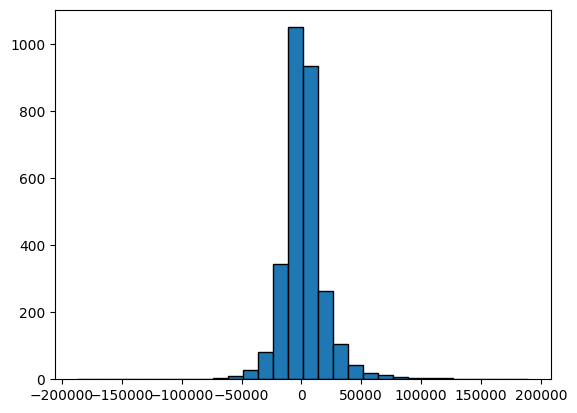

In [125]:
# Histogram
plt.hist(df['Residuals'], edgecolor='black', bins=30)
plt.show()

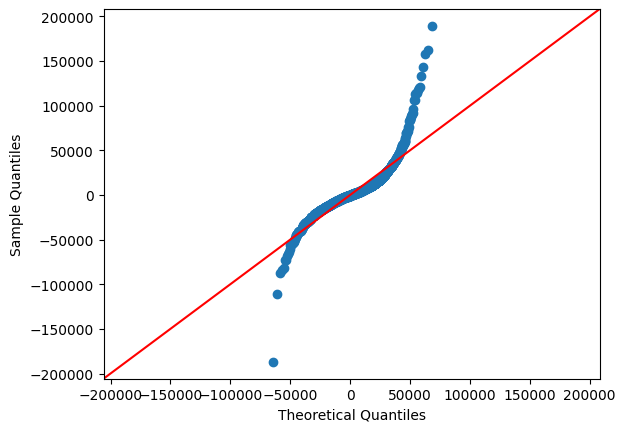

In [126]:
# QQ Plot
fig = sm.qqplot(df['Residuals'], loc= np.mean(df['Residuals']), scale= np.std(df['Residuals']), line='45')
plt.show()

**Investigate relationship between $Y_i$ and $\hat{Y_i}$ through scatterplot**

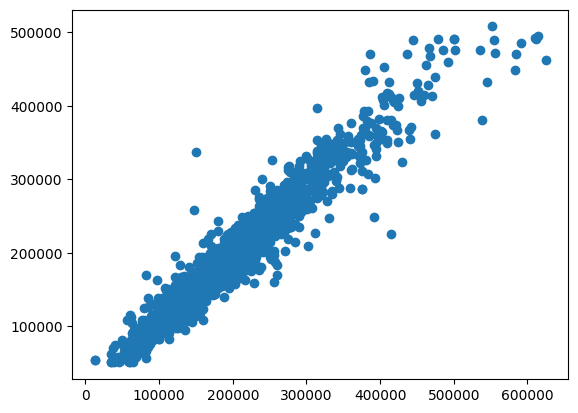

In [127]:
# Scatter plot
plt.scatter(df['SalePrice'], df['SalePricePrediction'])
plt.show()

# Model selection

**Estimate parameters of the following two models using maximum likelihood estimation. Use the likelihood ratio test and the AIC to determine the most appropriate model.**

Model 1: <br>
$Y_i \sim N\left(\hat{Y_i}, \sigma^2\right)$

Model 2: <br>
$Y_i \sim N\left(\hat{Y_i}, \left(\hat{Y_i}\sigma\right)^2\right)$

Model 3: <br>
$Y_i \sim N\left(\hat{Y_i}, \tau^2 + \left(\hat{Y_i}\sigma\right)^2\right)$

In [128]:
def neg_loglike_model1(theta):
    mu = df['SalePricePrediction']
    sd = theta[0]
    return -1*stats.norm(mu, sd).logpdf(df['SalePrice']).sum()


theta_start = np.array([1])
res = scipy.optimize.minimize(neg_loglike_model1, theta_start , method = 'Nelder-Mead',
           options={'disp': True})
sigma_mle1 = float(res['x'])
loglik1 = - res.fun
aic1 = 2*len(theta_start) - 2* loglik1

print(f"The theoretical MLE for sigma: {np.std(df['Residuals'])}")
print(f"The numerical MLE for sigma: {sigma_mle1}")
print(f"The loglikelihood: {loglik1}")
print(f"The AIC: {aic1}")

Optimization terminated successfully.
         Current function value: 33074.346428
         Iterations: 45
         Function evaluations: 93
The theoretical MLE for sigma: 19601.547666127182
The numerical MLE for sigma: 19703.08125000004
The loglikelihood: -33074.346427513956
The AIC: 66150.69285502791


In [129]:
def neg_loglike_model2(theta):
    mu = df['SalePricePrediction']
    sd = theta[0]*(df['SalePricePrediction'])
    return -1*stats.norm(mu, sd).logpdf(df['SalePrice']).sum()

theta_start = np.array([1])
res = scipy.optimize.minimize(neg_loglike_model2, theta_start, method = 'Nelder-Mead',
           options={'disp': True})
sigma_mle2 = float(res['x'])
loglik2 = - res.fun
aic2 = 2*len(theta_start) - 2* loglik2

print(f"The theoretical MLE for sigma: {np.std(df['SalePrice']/df['SalePricePrediction'])}")
print(f"The numerical MLE for sigma: {sigma_mle2}")
print(f"The loglikelihood: {loglik2}")
print(f"The AIC: {aic2}")

Optimization terminated successfully.
         Current function value: 32653.255567
         Iterations: 20
         Function evaluations: 40
The theoretical MLE for sigma: 0.10257141636718396
The numerical MLE for sigma: 0.10268554687499921
The loglikelihood: -32653.255567487016
The AIC: 65308.51113497403


In [130]:
def neg_loglike_model3(theta):
    mu = df['SalePricePrediction']
    sd = theta[0] + theta[1]*(df['SalePricePrediction'])
    return -1*stats.norm(mu, sd).logpdf(df['SalePrice']).sum()

theta_start = np.array([1,1])
res = scipy.optimize.minimize(neg_loglike_model3, theta_start, method = 'Nelder-Mead',
           options={'disp': True})

tau_mle3 = float(res['x'][0])
sigma_mle3 = float(res['x'][1])

loglik3 = - res.fun
aic3 = 2*len(theta_start) - 2* loglik3

print(f"The numerical MLE for tau: {tau_mle3}")
print(f"The numerical MLE for sigma: {sigma_mle3}")
print(f"The loglikelihood: {loglik3}")
print(f"The AIC: {aic3}")

Optimization terminated successfully.
         Current function value: 32598.250062
         Iterations: 120
         Function evaluations: 229
The numerical MLE for tau: 3871.045755873729
The numerical MLE for sigma: 0.07625665985552853
The loglikelihood: -32598.25006175047
The AIC: 65200.50012350094


Determine best model by comparing the AIC and applying the Likelihood Ratio Test.

Note that model 2 has a higher likelihood than model 1. Since their number of parameters is the same, model 2 outperforms model 1. Let us now compare model 2 and model 3.

In [131]:
# Likelihood ratio test
L = -2*(loglik2 - loglik3)

# P value
p_val = 1 - stats.chi2.cdf(L, 1)

print(f"The likelihood ratio test statistic equals: {L}")
print(f"The corresponding p-value equals: {p_val}")

The likelihood ratio test statistic equals: 110.01101147309237
The corresponding p-value equals: 0.0


We conclude that model 3 is the most adequate model. Now let's see how to calculate prediction intervals given these models.

# Prediction intervals

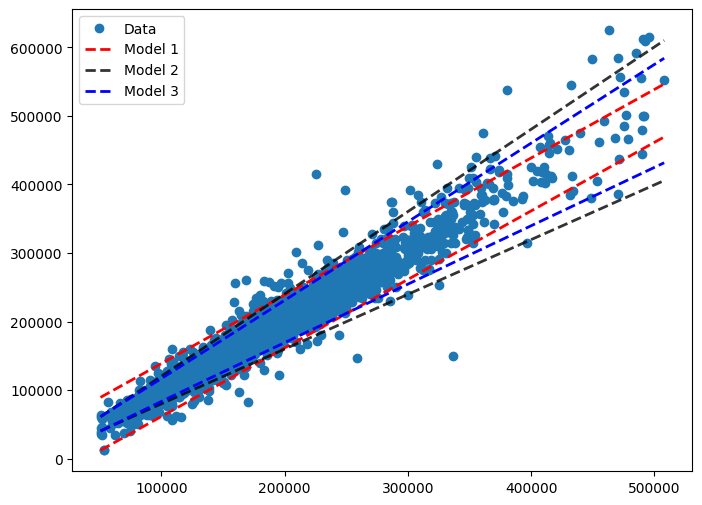

In [134]:
xx = np.arange(round(np.min(df['SalePricePrediction'])),round(np.max(df['SalePricePrediction'])))

# Prediction intervals for model 1
upper_1 = stats.norm.ppf(0.975, loc=xx, scale=sigma_mle1)
lower_1 = stats.norm.ppf(0.025, loc=xx, scale=sigma_mle1)

# Prediction intervals for model 2
upper_2 = stats.norm.ppf(0.975, loc=xx, scale=sigma_mle2*xx)
lower_2 = stats.norm.ppf(0.025, loc=xx, scale=sigma_mle2*xx)

# Prediction intervals for model 3
upper_3 = stats.norm.ppf(0.975, loc=xx, scale=np.sqrt(tau_mle3**2 + (sigma_mle3*xx)**2))
lower_3 = stats.norm.ppf(0.025, loc=xx, scale=np.sqrt(tau_mle3**2 + (sigma_mle3*xx)**2))


fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(df['SalePricePrediction'], df['SalePrice'], "o", label="Data")
# Model 1
ax.plot(xx, upper_1, "r--", label="Model 1", linewidth= 2)
ax.plot(xx, lower_1, "r--",  linewidth= 2)


# Model 2
ax.plot(xx, upper_2, "k--", label="Model 2", linewidth= 2, alpha=.8)
ax.plot(xx, lower_2, "k--",  linewidth= 2, alpha=.8)

# Model 3
ax.plot(xx, upper_3, "b--", label="Model 3", linewidth= 2)
ax.plot(xx, lower_3, "b--",  linewidth= 2)

ax.legend(loc="best")
fig.show()

**Confidence intervals do not equal prediction intervals**

In [133]:
#TODO

****